In [1]:
from glob import glob
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import json
import joblib
import cv2
from glob import glob
import numpy as np
import os

class CFG:
  random_state = 42
  pca_n_components = 3
  kmeans_n_clusters = 36


class Capcha:
  def __init__(self,root_folder):
    self.root_folder = root_folder

  def read_capcha(self,im_path):
    """
    Algo for reading capcha in a image
    args:
      im_path: path to image
    """
    index = im_path.split(os.path.sep)[-1].split('.')[0][-2:]
    image =  cv2.imread(os.path.join(self.root_folder,f'input/input{index}.jpg'))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply a binary threshold to invert the image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours (these will be the outlines of the characters)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Loop over the contours and extract individual characters
    characters = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Extract the character
        char = binary[y:y+h, x:x+w]
        width = char.shape[1]
        if width < 8:
          add_zeros = np.zeros((10,8-width))
          char = np.concatenate((char,add_zeros), axis=1)
        characters.append(char.flatten())
    return binary,characters

  def read_txt(self,txt_path):
    """
    Algo for reading txt file
    args:
      txt_path: path to txt file
    """
    with open(txt_path) as f:
      lines = [line.rstrip('\n') for line in f][0]
    return lines

  def read_data(self,im_folder,output_folder):
    """
    Algo for reading data for training
    args:
      im_folder: path to image folder
      output_folder: path to output folder
    """
    X = []
    y = []
    input_files = glob(os.path.join(im_folder,'*.jpg'))
    for index,im_file in enumerate(input_files):
      num = im_file.split(os.path.sep)[-1].split('.')[0][-2:]
      out_file = os.path.join(output_folder,f'output{num}.txt')
      if os.path.isfile(out_file):
        lines = self.read_txt(out_file)
        _,chars = self.read_capcha(im_file)
        if len(chars) == len(lines):
          X.append(chars)
          y.extend(lines[::-1])
    return np.vstack(X),y

  def train(self,X,y):
    """
    Algo for training model
    args:
      X: training data
      y: target
    """
    pipe = Pipeline([('sd', StandardScaler()), ('pca', PCA(n_components=CFG.pca_n_components,random_state=CFG.random_state)), ('kmeans', KMeans(n_clusters=CFG.kmeans_n_clusters,random_state=CFG.random_state))])
    pipe.fit(X)
    y_labels = [str(item) for item in pipe['kmeans'].labels_]
    map_dict = dict(zip(y_labels, y))
    model_path = os.path.join(self.root_folder,'model','capcha.pkl')
    joblib.dump(pipe, model_path)
    with open(os.path.join(self.root_folder,'model','cluster_label_to_capcha.json'), 'w') as fp:
      json.dump(map_dict, fp)
    return pipe,map_dict

  def get_prediction(self,clf,x):
    """
    Algo for getting prediction
    args:
      clf: trained model
      x: input data
    """
    y_pred = clf.predict(x)
    return y_pred

  def __call__(self,im_path,save_path):
    """
    Algo for inference
    args:
      im_path: path to image
      model_folder: path to model folder
      save_path: path to save output
    """
    binary,x = self.read_capcha(im_path)
    clf = joblib.load(os.path.join(self.model_folder,'capcha.pkl'))
    map_dict = json.load(open(os.path.join(self.model_folder,'cluster_label_to_capcha.json')))
    y_pred = self.get_prediction(clf,x)
    capcha_pred = ''.join([map_dict[str(pred)] for pred in y_pred[::-1]])
    with open(save_path,'w') as f:
      f.write(capcha_pred)
    return capcha_pred


ModuleNotFoundError: No module named 'cv2'

In [3]:
!pip install opencv-python

  Using cached opencv-python-4.10.0.84.tar.gz (95.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

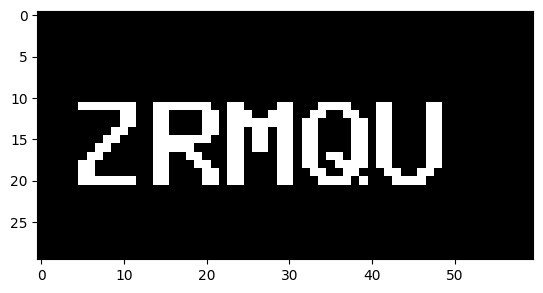

the identified capchas:ZRMQU


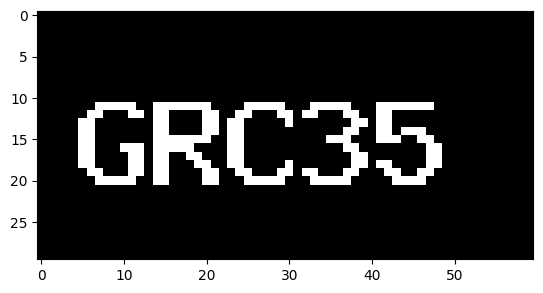

the identified capchas:GRC35


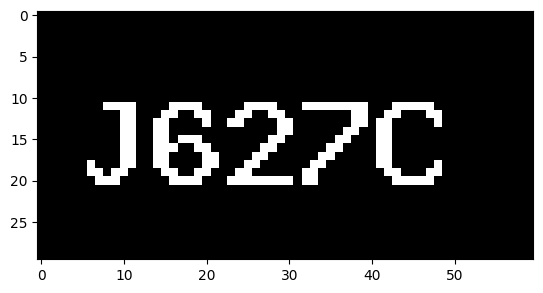

the identified capchas:J627C


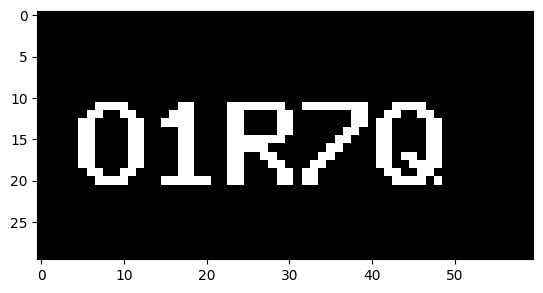

the identified capchas:O1R7Q


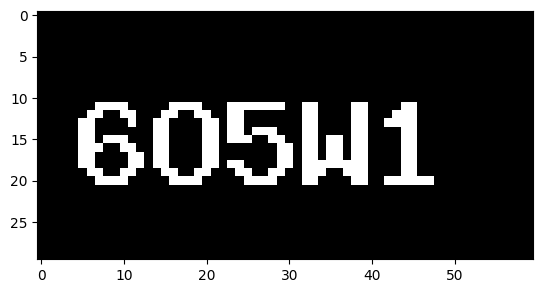

the identified capchas:6O5W1


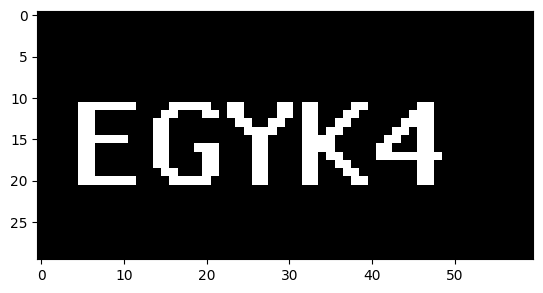

the identified capchas:EGYK4


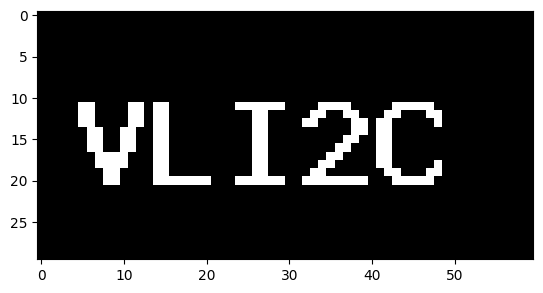

the identified capchas:VLI2C


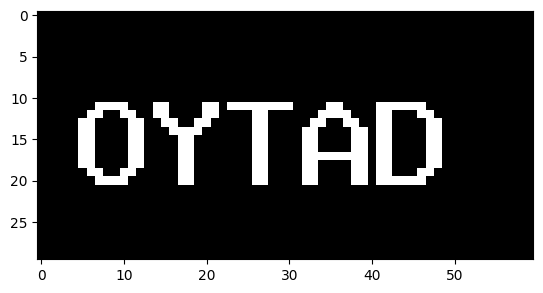

the identified capchas:OYTAD


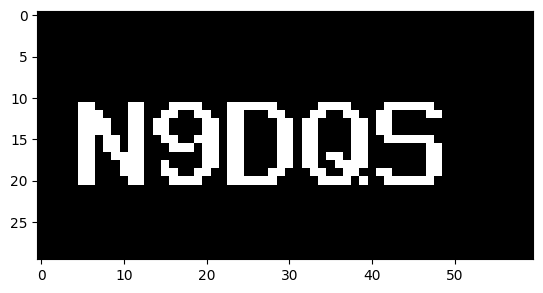

the identified capchas:N9DQS


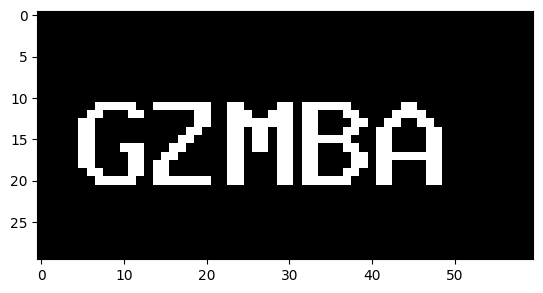

the identified capchas:GZMBA


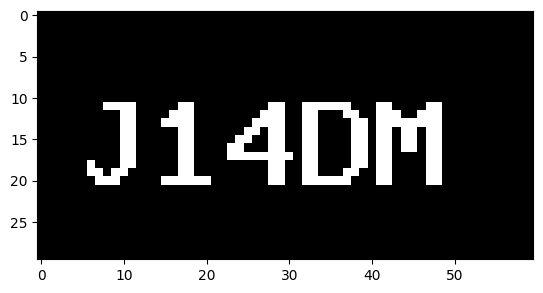

the identified capchas:J14DM


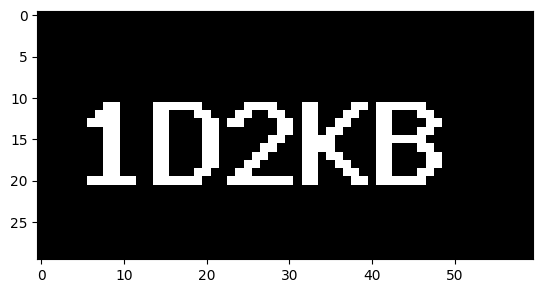

the identified capchas:1D2KB


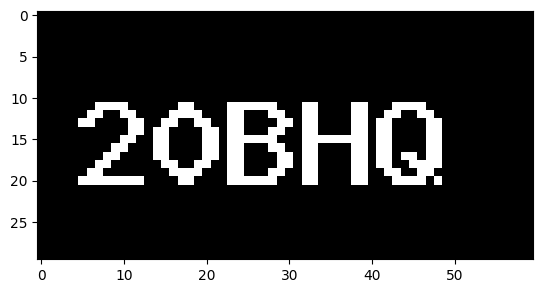

the identified capchas:20BHQ


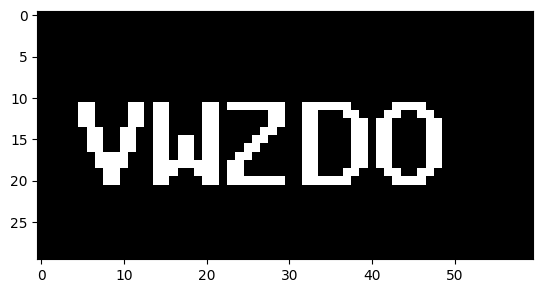

the identified capchas:VWZDO


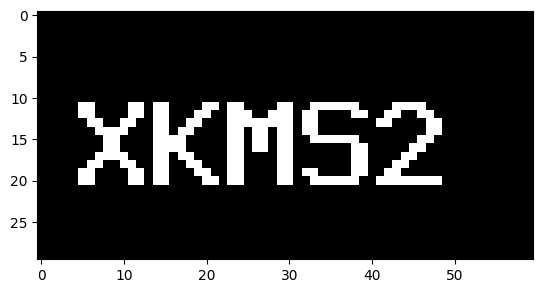

the identified capchas:XKMS2


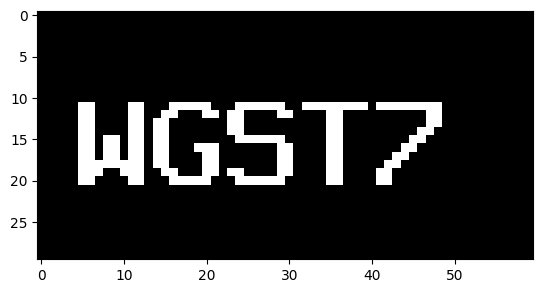

the identified capchas:WGST7


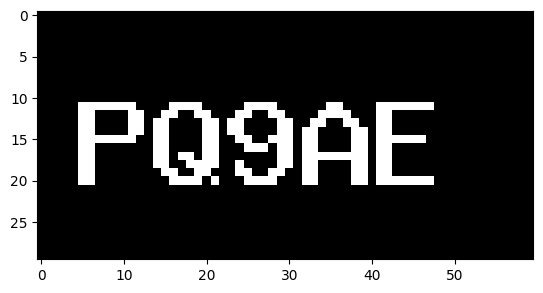

the identified capchas:PQ9AE


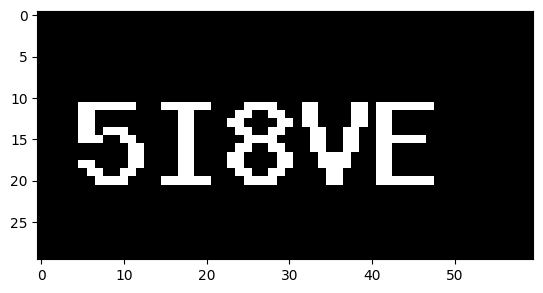

the identified capchas:5I8VE


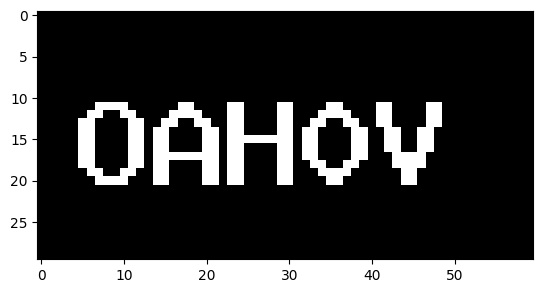

the identified capchas:OAH0V


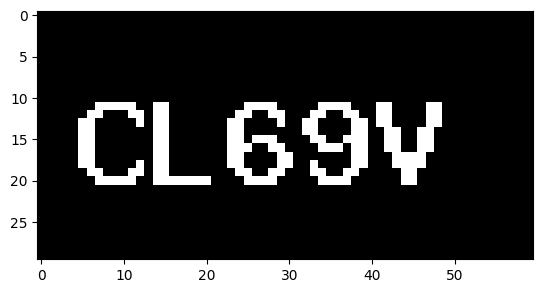

the identified capchas:CL69V


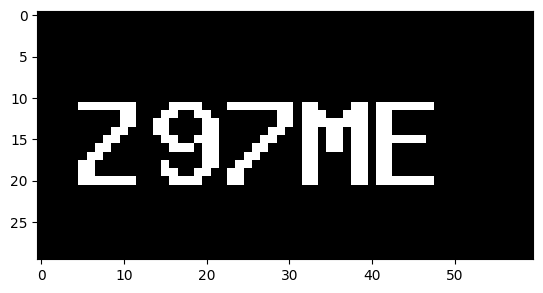

the identified capchas:Z97ME


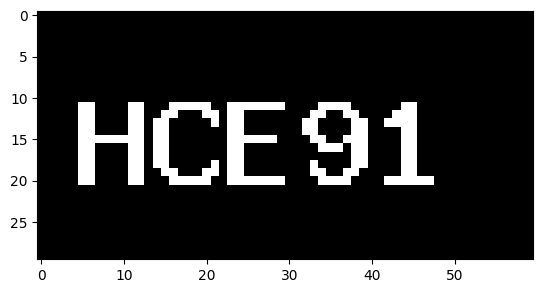

the identified capchas:HCE91


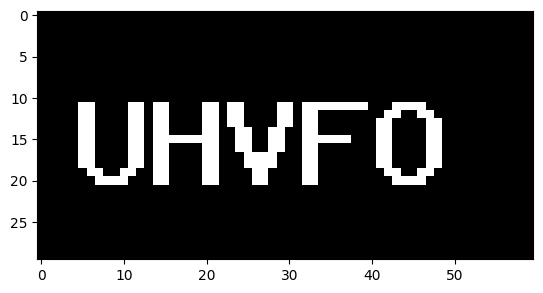

the identified capchas:UHVFO


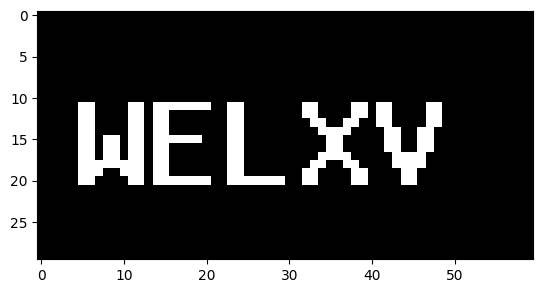

the identified capchas:WELXV


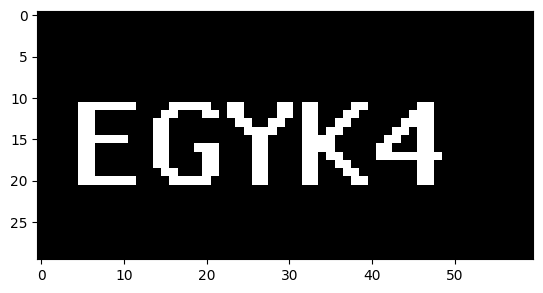

the identified capchas:EGYK4


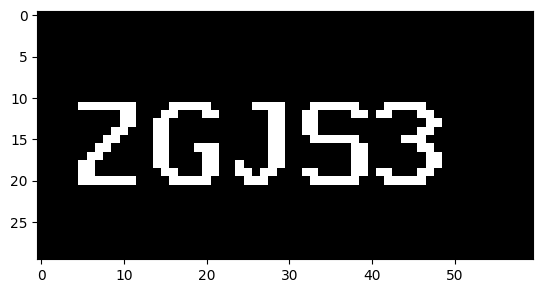

the identified capchas:ZGJS3


In [ ]:
if __name__ == '__main__':
  root_folder = './'
  capcha = Capcha(os.path.join(root_folder,'model'))
  input_files = glob(os.path.join(root_folder,'input','*.jpg'))

  #train the model if model file doesn't exist.
  if not os.path.isfile(os.path.join(root_folder,'model','capcha.pkl')):
    print('not model file, start to train')
    X,y = capcha.read_data(os.path.join(root_folder,'data','input'),os.path.join(root_folder,'data','output'))
    clf,map_dict = capcha.train(X,y)
  #predict the input images and save the output in the output files
  for input_file in input_files:
    binary,x = capcha.read_capcha(input_file)
    plt.imshow(binary, cmap='gray', vmin=0, vmax=255)
    plt.show()
    num = input_file.split(os.path.sep)[-1].split('.')[0][-2:]
    out_file = os.path.join(root_folder,'results',f'pred{num}.txt')
    capcha_pred = capcha(input_file,out_file)
    print(f'the identified capchas:{capcha_pred}')